# Logistische Regression: digits

Dieses Jupyter Notebook führt die Ergebnisse des zweiten Projektes im Modul Special Engineering (M30) zum Thema Logistische Regression auf. Als Datenset wird das digits Datenset verwendet.

In [1]:
###############################################################################
# Digits Dataset: Logistische Regression
# Sidney Göhler 544131
#### IKT (M)
# Special Engineering SoSe20
# Prof. Dr. Andreas Zeiser
###############################################################################
# Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec

from sklearn.datasets import load_digits

from sklearn.model_selection import GridSearchCV, ParameterGrid, train_test_split, StratifiedKFold, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score

import time
import pandas as pd
import tensorflow as tf
import seaborn as sns

from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import activations
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping #, TensorBoard



#from scipy.stats.kde import gaussian_kde
from scipy.stats import kde, distributions
##########################
#import helperfunctions
import helper

%load_ext autoreload
%autoreload 2


In [2]:
tf.keras.__version__

'2.3.0-tf'

In [3]:
####################
# load datasets
####################
dataset = load_digits()
#print(dataset.DESCR, '\n', '\n')
X = dataset.data
y = dataset.target

targets = dataset.target_names
images = dataset.images



### Visualisieren von einzelnen Ziffern
Nachdem das Datenset geladen wurde, können vereinzelte Zahlen illustriert werden.

digit = 0 at index = 0


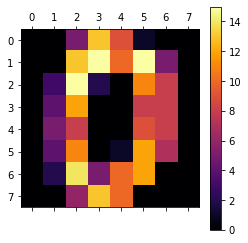

[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]



digit = 0 at index = 20


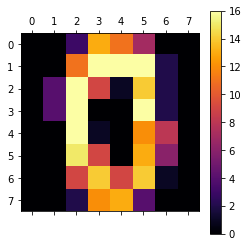

[[ 0.  0.  3. 13. 11.  7.  0.  0.]
 [ 0.  0. 11. 16. 16. 16.  2.  0.]
 [ 0.  4. 16.  9.  1. 14.  2.  0.]
 [ 0.  4. 16.  0.  0. 16.  2.  0.]
 [ 0.  0. 16.  1.  0. 12.  8.  0.]
 [ 0.  0. 15.  9.  0. 13.  6.  0.]
 [ 0.  0.  9. 14.  9. 14.  1.  0.]
 [ 0.  0.  2. 12. 13.  4.  0.  0.]]



digit = 8 at index = 500


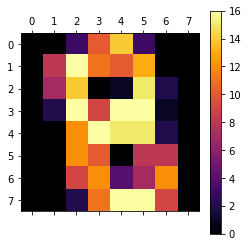

[[ 0.  0.  3. 10. 14.  3.  0.  0.]
 [ 0.  8. 16. 11. 10. 13.  0.  0.]
 [ 0.  7. 14.  0.  1. 15.  2.  0.]
 [ 0.  2. 16.  9. 16. 16.  1.  0.]
 [ 0.  0. 12. 16. 15. 15.  2.  0.]
 [ 0.  0. 12. 10.  0.  8.  8.  0.]
 [ 0.  0.  9. 12.  4.  7. 12.  0.]
 [ 0.  0.  2. 11. 16. 16.  9.  0.]]



digit = 8 at index = 508


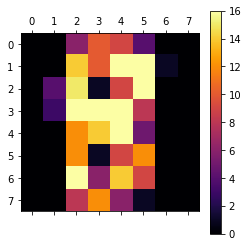

[[ 0.  0.  6. 10.  9.  4.  0.  0.]
 [ 0.  0. 14. 10. 16. 16.  1.  0.]
 [ 0.  4. 15.  1.  9. 16.  0.  0.]
 [ 0.  3. 16. 16. 16.  8.  0.  0.]
 [ 0.  0. 12. 14. 16.  5.  0.  0.]
 [ 0.  0. 12.  1.  9. 12.  0.  0.]
 [ 0.  0. 16.  6. 14.  9.  0.  0.]
 [ 0.  0.  8. 12.  6.  1.  0.  0.]]



digit = 5 at index = 1700


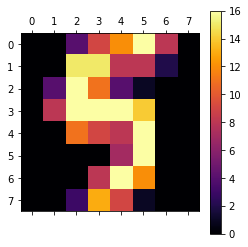

[[ 0.  0.  4.  9. 12. 16.  8.  0.]
 [ 0.  0. 15. 15.  8.  8.  2.  0.]
 [ 0.  4. 16. 11.  4.  1.  0.  0.]
 [ 0.  8. 16. 16. 16. 14.  0.  0.]
 [ 0.  0. 11.  9.  8. 16.  0.  0.]
 [ 0.  0.  0.  0.  7. 16.  0.  0.]
 [ 0.  0.  0.  8. 16. 12.  0.  0.]
 [ 0.  0.  3. 13.  9.  1.  0.  0.]]



digit = 5 at index = 1787


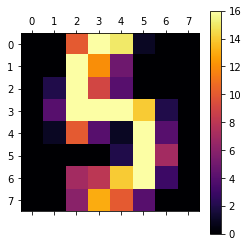

[[ 0.  0. 10. 16. 15.  1.  0.  0.]
 [ 0.  0. 16. 12.  5.  0.  0.  0.]
 [ 0.  2. 16.  9.  4.  0.  0.  0.]
 [ 0.  4. 16. 16. 16. 14.  2.  0.]
 [ 0.  1. 10.  4.  1. 16.  4.  0.]
 [ 0.  0.  0.  0.  2. 16.  7.  0.]
 [ 0.  0.  7.  8. 14. 16.  3.  0.]
 [ 0.  0.  6. 13. 10.  4.  0.  0.]]





In [4]:
for ind in [0,20,500,508,1700,1787]:
    print(f'digit = {y[ind]} at index = {ind}')
    plt.matshow(images[ind], cmap = cm.inferno)
    plt.colorbar()
    plt.show()
    print(f'{images[ind]}\n\n\n')

Zu sehen ist, dass die selben Ziffern häufig minimale Unterschiede untereinander haben. Die Zeilen 3 und 4 wirken stark frequentiert, hingegen die Spalten 0 und 7 sehr schwach.

Anzumerken ist noch, dass die Features des Datensets, aufgrund der Tatsache, dass es sich ausschlißelich um Helligkeitswerte handelt, bereits skaliert sind.
Ein erneutes skalieren ist somit nicht unbedingt Notwendig aber dennoch ratsam, da das Gradientenabstiegsverfahren wohl deutlich schneller Konvergiert.
https://en.wikipedia.org/wiki/Feature_scaling#cite_note-1

In [5]:
X = X/16

#mean, std = lr.StandardScaler_fit(X)
#print(mean,std)
#X = lr.StandardScaler_transform(X, mean, std+10)
#print(np.max(X),np.min(X))

Auffälig ist dennoch,wenn man sich den Mittelwert und die Standartabweichung der einzelnen Features anschaut, fällt nochmals auf, dass beide bei drei Features jeweils 0.0 ist, was eigentlich bedeuted, dass es zwischen den einzelnen digits bei diesen Features keine Unterschiede gibt, welche für Verhersagungen genutz werden können.
Somit könnten diese drei Features komplett ausgeschlossen werden um ggf. Prozessorzeit oder Speicher zu sparen.

In [6]:
####################
# split dataset (80:20)
####################


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.50, random_state=42)

print('trainset ',np.shape(X_train),np.shape(y_train),
      '\ntestset ', np.shape(X_test),np.shape(y_test),
      '\nvalidationset ',np.shape(X_val),np.shape(y_val))

trainset  (1078, 64) (1078,) 
testset  (359, 64) (359,) 
validationset  (360, 64) (360,)


D:\Documents\Uni\!code\git\python\ann\helper.py:37: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  ax2.stem([0],[0.1], '-.')


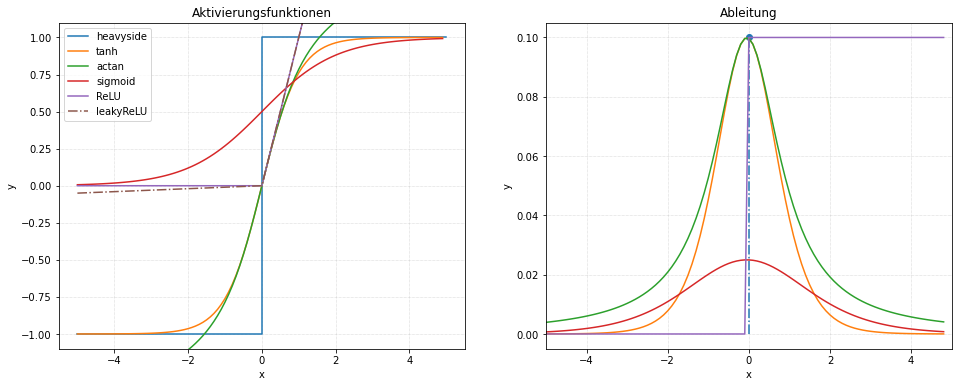

In [7]:

helper.plotactivationfunctions()



Lineare Aktivierungsfunktionen unterliegen einer starken Beschränkung, da eine Komposition linearer Funktionen durch arithmetische Umformungen durch eine einzige lineare Funktion dargestellt werden kann. Für mehrschichtige Verbindungsnetzwerke sind sie deswegen nicht geeignet und finden so nur in einfachen Modellen Anwendung. 

In [8]:
#https://keras.io/api/layers/regularizers/
def create_model(n_hidden_layer=1, n_neurons_per_layer=32, learning_rate=5e-4, optimizer="SGD"):
    model = Sequential()

    model.add(layers.Dense(64, activation='relu', input_shape=(64,)))
    
    for lay in range(n_hidden_layer):
        model.add(layers.Dense(n_neurons_per_layer, activation='relu', activity_regularizer=regularizers.l2(learning_rate)))

    model.add(layers.Dense(10, activation='softmax'))
    
    model.compile(loss="sparse_categorical_crossentropy",
             optimizer=optimizer,
             metrics=["accuracy"])
    
    return model


model_path = "!digit_classifier_{}.h5".format(time.time())
#model_path = "!digit_classifier_1572964918.600015.h5"

learning_rate = 5e-4
nb_epoch = 300
nb_batch_size = 20



model_sk = KerasClassifier(build_fn=create_model)


In [ ]:
model.summary()

In [ ]:
checkpointer = ModelCheckpoint(filepath=model_path,
                               verbose=1,
                               save_best_only=True)

early_stopping = EarlyStopping(patience=5,
                               verbose=1,
                               restore_best_weights=True)

In [10]:
from scipy.stats import reciprocal

scorer = make_scorer(f1_score, average='weighted')


param_grid = {
     #'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'n_hidden_layer': [3, 4],
    'n_neurons_per_layer': [64, 128],
    'learning_rate': [5e-4, 5e-3, 5e-2],
    #'n_jobs':[-1],
    #'random_state': [seed]
}

grid = GridSearchCV(estimator=model_sk,
                    param_grid=param_grid,
                    scoring=scorer,
                    verbose=10,
                    #n_jobs=-1,
                    cv=3)

grid_result = grid.fit(X_train, y_train, epochs=nb_epoch,
                    shuffle=True,
                    batch_size=nb_batch_size,
                    validation_data=(X_val, y_val),
                    verbose=0,
                    callbacks=[checkpointer, early_stopping])


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] learning_rate=0.0005, n_hidden_layer=3, n_neurons_per_layer=64 ..


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
[CV]  learning_rate=0.0005, n_hidden_layer=3, n_neurons_per_layer=64, score=0.961, total= 1.2min
[CV] learning_rate=0.0005, n_hidden_layer=3, n_neurons_per_layer=64 ..


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV]  learning_rate=0.0005, n_hidden_layer=3, n_neurons_per_layer=64, score=0.958, total= 1.2min
[CV] learning_rate=0.0005, n_hidden_layer=3, n_neurons_per_layer=64 ..


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min remaining:    0.0s


[CV]  learning_rate=0.0005, n_hidden_layer=3, n_neurons_per_layer=64, score=0.955, total= 1.3min
[CV] learning_rate=0.0005, n_hidden_layer=3, n_neurons_per_layer=128 .


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.7min remaining:    0.0s


[CV]  learning_rate=0.0005, n_hidden_layer=3, n_neurons_per_layer=128, score=0.953, total= 1.3min
[CV] learning_rate=0.0005, n_hidden_layer=3, n_neurons_per_layer=128 .


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  5.0min remaining:    0.0s


[CV]  learning_rate=0.0005, n_hidden_layer=3, n_neurons_per_layer=128, score=0.978, total= 1.2min
[CV] learning_rate=0.0005, n_hidden_layer=3, n_neurons_per_layer=128 .


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.2min remaining:    0.0s


[CV]  learning_rate=0.0005, n_hidden_layer=3, n_neurons_per_layer=128, score=0.958, total= 1.2min
[CV] learning_rate=0.0005, n_hidden_layer=4, n_neurons_per_layer=64 ..


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  7.5min remaining:    0.0s


[CV]  learning_rate=0.0005, n_hidden_layer=4, n_neurons_per_layer=64, score=0.944, total= 1.3min
[CV] learning_rate=0.0005, n_hidden_layer=4, n_neurons_per_layer=64 ..


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  8.8min remaining:    0.0s


[CV]  learning_rate=0.0005, n_hidden_layer=4, n_neurons_per_layer=64, score=0.966, total= 1.3min
[CV] learning_rate=0.0005, n_hidden_layer=4, n_neurons_per_layer=64 ..


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 10.1min remaining:    0.0s


[CV]  learning_rate=0.0005, n_hidden_layer=4, n_neurons_per_layer=64, score=0.964, total= 1.6min
[CV] learning_rate=0.0005, n_hidden_layer=4, n_neurons_per_layer=128 .


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 11.7min remaining:    0.0s


[CV]  learning_rate=0.0005, n_hidden_layer=4, n_neurons_per_layer=128, score=0.947, total= 1.9min
[CV] learning_rate=0.0005, n_hidden_layer=4, n_neurons_per_layer=128 .
[CV]  learning_rate=0.0005, n_hidden_layer=4, n_neurons_per_layer=128, score=0.977, total= 1.3min
[CV] learning_rate=0.0005, n_hidden_layer=4, n_neurons_per_layer=128 .
[CV]  learning_rate=0.0005, n_hidden_layer=4, n_neurons_per_layer=128, score=0.972, total= 1.8min
[CV] learning_rate=0.005, n_hidden_layer=3, n_neurons_per_layer=64 ...
[CV]  learning_rate=0.005, n_hidden_layer=3, n_neurons_per_layer=64, score=0.953, total= 1.9min
[CV] learning_rate=0.005, n_hidden_layer=3, n_neurons_per_layer=64 ...
[CV]  learning_rate=0.005, n_hidden_layer=3, n_neurons_per_layer=64, score=0.972, total= 2.3min
[CV] learning_rate=0.005, n_hidden_layer=3, n_neurons_per_layer=64 ...
[CV]  learning_rate=0.005, n_hidden_layer=3, n_neurons_per_layer=64, score=0.967, total= 2.1min
[CV] learning_rate=0.005, n_hidden_layer=3, n_neurons_per_layer

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 69.2min finished


In [22]:
print(f'{grid.best_params_} with {grid.best_score_}')

{'learning_rate': 0.05, 'n_hidden_layer': 3, 'n_neurons_per_layer': 128} with 0.9705192334892251


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 6,570
Trainable params: 6,570
Non-trainable params: 0
_________________________________________________________________


In [ ]:
bestmodel = create_model(**grid.best_params_)

In [12]:
history = bestmodel.fit(X_train, y_train, epochs=nb_epoch,
                    shuffle=True,
                    batch_size=nb_batch_size,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=[checkpointer, early_stopping])

Epoch 1/300
54/54 [==============================] - 1s 15ms/step - loss: 2.2834 - accuracy: 0.1364 - val_loss: 2.2257 - val_accuracy: 0.2083
Epoch 2/300
54/54 [==============================] - 1s 16ms/step - loss: 2.1815 - accuracy: 0.2857 - val_loss: 2.1343 - val_accuracy: 0.3722
Epoch 3/300
54/54 [==============================] - 1s 12ms/step - loss: 2.0838 - accuracy: 0.4017 - val_loss: 2.0314 - val_accuracy: 0.4833
Epoch 4/300
54/54 [==============================] - 1s 13ms/step - loss: 1.9720 - accuracy: 0.5288 - val_loss: 1.9091 - val_accuracy: 0.5944
Epoch 5/300
54/54 [==============================] - 1s 10ms/step - loss: 1.8440 - accuracy: 0.6456 - val_loss: 1.7716 - val_accuracy: 0.6889
Epoch 6/300
54/54 [==============================] - 1s 11ms/step - loss: 1.7003 - accuracy: 0.6883 - val_loss: 1.6217 - val_accuracy: 0.7361
Epoch 7/300
54/54 [==============================] - 1s 21ms/step - loss: 1.5453 - accuracy: 0.7365 - val_loss: 1.4652 - val_accuracy: 0.7667
Epoch 

54/54 [==============================] - 1s 10ms/step - loss: 0.1696 - accuracy: 0.9750 - val_loss: 0.1920 - val_accuracy: 0.9639
Epoch 59/300
54/54 [==============================] - 1s 18ms/step - loss: 0.1683 - accuracy: 0.9750 - val_loss: 0.1913 - val_accuracy: 0.9611
Epoch 60/300
54/54 [==============================] - 1s 19ms/step - loss: 0.1655 - accuracy: 0.9750 - val_loss: 0.1904 - val_accuracy: 0.9639
Epoch 61/300
54/54 [==============================] - 1s 15ms/step - loss: 0.1641 - accuracy: 0.9740 - val_loss: 0.1865 - val_accuracy: 0.9667
Epoch 62/300
54/54 [==============================] - 1s 16ms/step - loss: 0.1617 - accuracy: 0.9740 - val_loss: 0.1858 - val_accuracy: 0.9611
Epoch 63/300
54/54 [==============================] - 1s 16ms/step - loss: 0.1599 - accuracy: 0.9759 - val_loss: 0.1845 - val_accuracy: 0.9639
Epoch 64/300
54/54 [==============================] - 1s 13ms/step - loss: 0.1572 - accuracy: 0.9768 - val_loss: 0.1844 - val_accuracy: 0.9667
Epoch 65/300

54/54 [==============================] - 1s 10ms/step - loss: 0.1014 - accuracy: 0.9907 - val_loss: 0.1418 - val_accuracy: 0.9667
Epoch 116/300
54/54 [==============================] - 1s 11ms/step - loss: 0.1005 - accuracy: 0.9917 - val_loss: 0.1411 - val_accuracy: 0.9750
Epoch 117/300
54/54 [==============================] - 1s 10ms/step - loss: 0.1002 - accuracy: 0.9917 - val_loss: 0.1411 - val_accuracy: 0.9694
Epoch 118/300
54/54 [==============================] - 1s 11ms/step - loss: 0.0983 - accuracy: 0.9935 - val_loss: 0.1420 - val_accuracy: 0.9694
Epoch 119/300
54/54 [==============================] - 1s 16ms/step - loss: 0.0990 - accuracy: 0.9917 - val_loss: 0.1400 - val_accuracy: 0.9694
Epoch 120/300
54/54 [==============================] - 1s 10ms/step - loss: 0.0981 - accuracy: 0.9917 - val_loss: 0.1397 - val_accuracy: 0.9722
Epoch 121/300
54/54 [==============================] - 1s 13ms/step - loss: 0.0976 - accuracy: 0.9917 - val_loss: 0.1391 - val_accuracy: 0.9722
Epoch 

Epoch 172/300
54/54 [==============================] - 1s 15ms/step - loss: 0.0733 - accuracy: 0.9954 - val_loss: 0.1233 - val_accuracy: 0.9722
Epoch 173/300
54/54 [==============================] - 1s 9ms/step - loss: 0.0732 - accuracy: 0.9963 - val_loss: 0.1230 - val_accuracy: 0.9750
Epoch 174/300
54/54 [==============================] - 1s 11ms/step - loss: 0.0724 - accuracy: 0.9972 - val_loss: 0.1231 - val_accuracy: 0.9722
Epoch 175/300
54/54 [==============================] - 1s 11ms/step - loss: 0.0724 - accuracy: 0.9972 - val_loss: 0.1220 - val_accuracy: 0.9750
Epoch 176/300
54/54 [==============================] - 1s 11ms/step - loss: 0.0720 - accuracy: 0.9963 - val_loss: 0.1218 - val_accuracy: 0.9750
Epoch 177/300
54/54 [==============================] - 0s 9ms/step - loss: 0.0717 - accuracy: 0.9972 - val_loss: 0.1220 - val_accuracy: 0.9750
Epoch 178/300
54/54 [==============================] - 1s 11ms/step - loss: 0.0713 - accuracy: 0.9963 - val_loss: 0.1223 - val_accuracy: 0

Epoch 229/300
54/54 [==============================] - 1s 11ms/step - loss: 0.0580 - accuracy: 0.9981 - val_loss: 0.1126 - val_accuracy: 0.9778
Epoch 230/300
54/54 [==============================] - 1s 11ms/step - loss: 0.0580 - accuracy: 0.9981 - val_loss: 0.1134 - val_accuracy: 0.9778
Epoch 231/300
54/54 [==============================] - 1s 16ms/step - loss: 0.0578 - accuracy: 0.9981 - val_loss: 0.1136 - val_accuracy: 0.9778
Epoch 232/300
54/54 [==============================] - 1s 14ms/step - loss: 0.0575 - accuracy: 0.9981 - val_loss: 0.1125 - val_accuracy: 0.9778
Epoch 233/300
54/54 [==============================] - 1s 13ms/step - loss: 0.0574 - accuracy: 0.9981 - val_loss: 0.1124 - val_accuracy: 0.9778
Epoch 234/300
54/54 [==============================] - 1s 12ms/step - loss: 0.0571 - accuracy: 0.9981 - val_loss: 0.1130 - val_accuracy: 0.9778
Epoch 235/300
54/54 [==============================] - 1s 13ms/step - loss: 0.0569 - accuracy: 0.9981 - val_loss: 0.1122 - val_accuracy:

Epoch 286/300
54/54 [==============================] - 1s 16ms/step - loss: 0.0487 - accuracy: 0.9991 - val_loss: 0.1068 - val_accuracy: 0.9778
Epoch 287/300
54/54 [==============================] - 1s 14ms/step - loss: 0.0486 - accuracy: 0.9991 - val_loss: 0.1065 - val_accuracy: 0.9778
Epoch 288/300
54/54 [==============================] - 1s 12ms/step - loss: 0.0483 - accuracy: 0.9991 - val_loss: 0.1064 - val_accuracy: 0.9778
Epoch 289/300
54/54 [==============================] - 1s 11ms/step - loss: 0.0483 - accuracy: 1.0000 - val_loss: 0.1063 - val_accuracy: 0.9778
Epoch 290/300
54/54 [==============================] - 1s 12ms/step - loss: 0.0482 - accuracy: 0.9991 - val_loss: 0.1065 - val_accuracy: 0.9778
Epoch 291/300
54/54 [==============================] - 1s 12ms/step - loss: 0.0481 - accuracy: 0.9991 - val_loss: 0.1064 - val_accuracy: 0.9778
Epoch 292/300
54/54 [==============================] - 1s 11ms/step - loss: 0.0479 - accuracy: 0.9991 - val_loss: 0.1063 - val_accuracy:

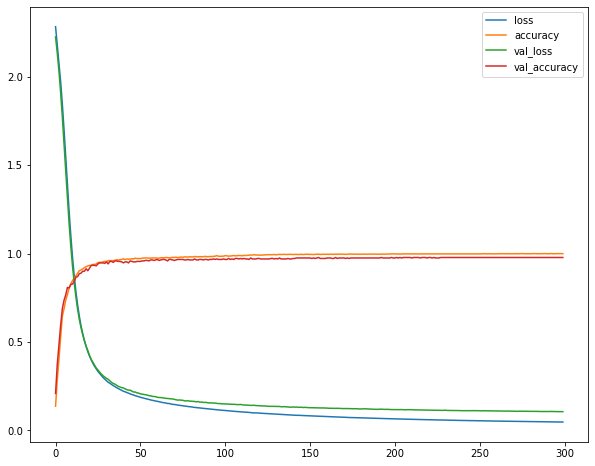

In [13]:
pd.DataFrame(history.history).plot(figsize=(10,8))

In [14]:
predictions = bestmodel.predict(X_test)

y_pred = np.zeros(np.shape(y_test))

In [15]:
for ind, pred in enumerate(predictions):
    y_pred[ind] = np.argmax(pred)

In [16]:
cnf_matrix = confusion_matrix(y_test,y_pred)

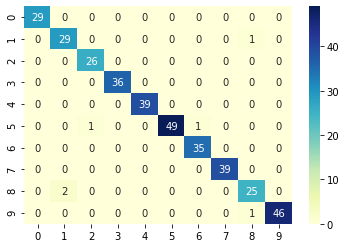

In [17]:
sns.heatmap(cnf_matrix, cmap='YlGnBu', annot=True)

In [18]:
print(classification_report(y_test, y_pred, output_dict=False))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       0.94      0.97      0.95        30
           2       0.96      1.00      0.98        26
           3       1.00      1.00      1.00        36
           4       1.00      1.00      1.00        39
           5       1.00      0.96      0.98        51
           6       0.97      1.00      0.99        35
           7       1.00      1.00      1.00        39
           8       0.93      0.93      0.93        27
           9       1.00      0.98      0.99        47

    accuracy                           0.98       359
   macro avg       0.98      0.98      0.98       359
weighted avg       0.98      0.98      0.98       359



In [19]:
# Calculate uncertainty values for each transduced distribution
pred_entropies = distributions.entropy(predictions)

In [20]:
# Pick the top 10 most uncertain labels
uncertainty_index = np.argsort(pred_entropies)[-10:]

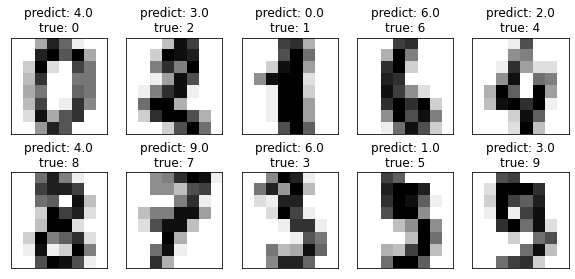

In [21]:
# Plot
f = plt.figure(figsize=(10, 7))
for index, image_index in enumerate(uncertainty_index):
    #print(index,image_index)
    image = images[image_index]

    sub = f.add_subplot(3, 5, index + 1)
    sub.imshow(image, cmap=plt.cm.gray_r)
    plt.xticks([])
    plt.yticks([])
    sub.set_title(f'predict: {y_pred[image_index]}\ntrue: {y[image_index]}')